In [ ]:
pip install torch

In [ ]:
pip install torchdiffeq

In [1]:
import autograd.numpy as np
from autograd import grad, jacobian
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
#import torch
#from torchdiffeq import odeint

In [2]:


# Define HH model parameters
g_Na = 120.0  # Sodium conductance (mS/cm^2)
g_K = 36.0   # Potassium conductance (mS/cm^2)
g_L = 0.3    # Leak conductance (mS/cm^2)
E_Na = 50.0  # Sodium reversal potential (mV)
E_K = -77.0  # Potassium reversal potential (mV)
E_L = -55.0  # Leak reversal potential (mV)
C_m = 1.0    # Membrane capacitance (uF/cm^2)

# Define the HH model equations
def alpha_m(V):
    return 0.1 * (V + 40.0) / (1.0 - np.exp(-(V + 40.0) / 10.0))

def beta_m(V):
    return 4.0 * np.exp(-(V + 65.0) / 18.0)

def alpha_h(V):
    return 0.07 * np.exp(-(V + 65.0) / 20.0)

def beta_h(V):
    return 1.0 / (1.0 + np.exp(-(V + 35.0) / 10.0))

def alpha_n(V):
    return 0.01 * (V + 55.0) / (1.0 - np.exp(-(V + 55.0) / 10.0))

def beta_n(V):
    return 0.125 * np.exp(-(V + 65) / 80.0)

# Define the HH model differential equations
def hodgkin_huxley_eq(V, m, h, n, I_params, t):
    I = I_params[0]*np.sin(I_params[1]*t)
    dVdt = (I - g_Na * m**3 * h * (V - E_Na) - g_K * n**4 * (V - E_K) - g_L * (V - E_L)) / C_m
    dmdt = alpha_m(V) * (1 - m) - beta_m(V) * m
    dhdt = alpha_h(V) * (1 - h) - beta_h(V) * h
    dndt = alpha_n(V) * (1 - n) - beta_n(V) * n
    return dVdt, dmdt, dhdt, dndt

# Define time parameters
dt = 0.01  # Time step (ms)
t = np.arange(0, 50, dt)  # Time vector (ms)

# Define input stimulus waveform (e.g., a step current)
I_stimulus = np.zeros_like(t)
I_stimulus[100:500] = 10.0  # Apply a current step from 100 ms to 500 ms

# Initialize state variables
V0 = -65.0  # Membrane voltage (mV)
m, h, n = 0.05, 0.6, 0.32  # Initial values of gating variables

# Simulate the HH model and record data
V_record = np.zeros_like(t)
V = V0

A = 1.0
w = 1.0

I_params = np.array([A, w])

for i in range(len(t)):
    V_record[i] = V
    dVdt, dmdt, dhdt, dndt = hodgkin_huxley_eq(V, m, h, n, I_params, t[i])
    V += dVdt * dt
    m += dmdt * dt
    h += dhdt * dt
    n += dndt * dt

  

In [3]:
def integrate_HH(V0, m, h, n, I_params, dt, t):
    
    V_record = np.zeros_like(t)
    V = V0
    
    for i in range(len(t)):
        V_record[i] = V
        dVdt, dmdt, dhdt, dndt = hodgkin_huxley_eq(V, m, h, n, I_params, t[i])
        V += dVdt * dt
        m += dmdt * dt
        h += dhdt * dt
        n += dndt * dt
    return V_record


    

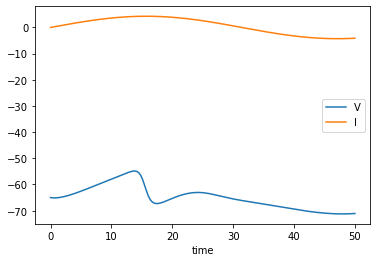

In [57]:
A = 4.289
w = 0.1

I_params = np.array([A, w])

V_record = integrate_HH(V0, m, h, n, I_params, dt, t)

I_stimulus = A*np.sin(w*t)

plt.plot(t, V_record, label = 'V')
plt.plot(t, I_stimulus, label = 'I')
plt.xlabel('time')
plt.legend()

In [5]:


def hodgkin_huxley_neural_ode(t, z, I_stimulus):
    V, m, h, n = z
    dVdt, dmdt, dhdt, dndt = hodgkin_huxley_eq(V, m, h, n, I_stimulus)
    return [dVdt, dmdt, dhdt, dndt]

# Create a function to solve the neural ODE
def solve_neural_ode(I_stimulus, t_span):
    z0 = [-65.0, 0.05, 0.6, 0.32]  # Initial conditions for V, m, h, n
    return odeint(hodgkin_huxley_neural_ode, torch.tensor(z0), t_span, args=(I_stimulus,))


## Adjoint

#### Fake Data

In [ ]:
# #np.load('./sim_data/t_vec.p', allow_pickle = True)
# import pickle

# import neuron.hoc39
# #from neuron import h, gui
# t_file = './sim_data/t_vec.p'


# with open(t_file, mode='rb') as f:
#     t_data = pickle.load(f)


In [58]:
# run forward model to create fake data to test adjoint

# Initialize state variables
V = -65.0  # Membrane voltage (mV)
m, h, n = 0.05, 0.6, 0.32  # Initial values of gating variables


V_subsamp = V_record[::10]
    
mean = np.mean(V_record)
stddev = np.std(V_record)

noise = np.random.normal(0, stddev, len(V_subsamp))
#noise = np.random.normal(0,1,len(V_subsamp))
V_data = V_subsamp + noise

data_steps = t[::10]

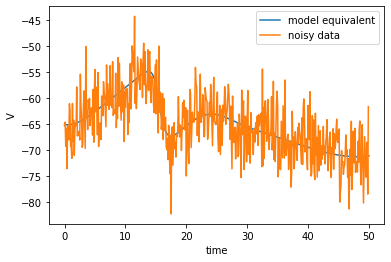

In [59]:
plt.plot(t, V_record, label = 'model equivalent')
plt.plot(data_steps, V_data, label = 'noisy data')
plt.xlabel('time')
plt.ylabel('V')
plt.legend()

#### Compute Gradient

In [75]:
def forward_model_cost(I_params, V0, m, h, n, dt, t, data_steps, V_data):

    cost = 0
        
    #V_record = np.zeros(len(t), dtype=t.dtype)
    V_record = []
    V = V0
    
    for i in range(len(t)):
        
        # run forward step
        V_record.append(V)
        #V_record[i] = V
        
        #I = A*np.sin(w*t[i])
        #I = I_stimulus[i]
        
        dVdt, dmdt, dhdt, dndt = hodgkin_huxley_eq(V, m, h, n, I_params, t[i])
        V += dVdt * dt
        m += dmdt * dt
        h += dhdt * dt
        n += dndt * dt

        # compute model-data misfit
        if t[i] in data_steps:
            j = np.where(data_steps == t[i])
            cost += (V_record[i] - V_data[j])**2
            
    #return V_record, cost
    return cost


        
        

In [76]:
# Initialize state variables
# V0 = np.float64(-65.0)  # Membrane voltage (mV)
# m, h, n = 0.05, 0.6, 0.32  # Initial values of gating variables


total_cost = forward_model_cost(I_params, V0, m, h, n, dt, t, data_steps, V_data)

total_cost



array([9198.96005794])

In [77]:
import autograd.numpy as np
from autograd import grad, jacobian

grad_AD = grad(forward_model_cost, 0) # 4 indicates differentiation w.r.t. the fourth argument of f.
# second argument indicates differentiation wrt to that number argument of the fn to differentiate


In [87]:
# test autograd

grad_AD(I_params, V0, m, h, n, dt, t, data_steps, V_data)
#jac_AD(V, m, h, n, I_stimulus, dt, t, data_steps, V_data)

array([ 21793.44283367, 681148.58995116])

#### FD Check

In [80]:
# FD check wrt A

A1 = np.random.uniform(0,5)
L1 = forward_model_cost(np.array([A1, w]), V0, m, h, n, dt, t, data_steps, V_data)

p = np.random.randint(0,5000)
s = 1e-7 # step size
A2 = A1 + s*p
L2 = forward_model_cost(np.array([A2, w]), V0, m, h, n, dt, t, data_steps, V_data)
dL_dV_p_diff = (L2 - L1) / s

g = grad_AD(np.array([A1, w]), V, m, h, n, dt, t, data_steps, V_data)[0]
dL_dV_p = np.dot(g, p)

grad_err = np.abs( (dL_dV_p - dL_dV_p_diff) / dL_dV_p_diff )
print('step size=', s, ', gradient finite difference error=', grad_err)




# # FD check wrt w

# w1 = np.random.uniform(0, 1)
# L1 = forward_model_cost(V0, m, h, n, np.array([A, w1]), dt, t, data_steps, V_data)

# p = np.random.randint(0,5000)
# s = 1e-7 # step size
# w2 = w1 + s*p
# L2 = forward_model_cost(V0, m, h, n, np.array([A, w2]), dt, t, data_steps, V_data)
# dL_dV_p_diff = (L2 - L1) / s

# g = grad_AD(V, m, h, n, np.array([A, w1]), dt, t, data_steps, V_data)[1]
# dL_dV_p = np.dot(g, p)

# grad_err = np.abs( (dL_dV_p - dL_dV_p_diff) / dL_dV_p_diff )
# print('step size=', s, ', gradient finite difference error=', grad_err)





step size= 1e-07 , gradient finite difference error= [6.91287703e-05]


/var/folders/6j/fcfm9_6n3rg0rg4_4flv5ks00000gq/T/ipykernel_59888/2018758815.py:32: RuntimeWarning: invalid value encountered in scalar subtract
  dVdt = (I - g_Na * m**3 * h * (V - E_Na) - g_K * n**4 * (V - E_K) - g_L * (V - E_L)) / C_m
/var/folders/6j/fcfm9_6n3rg0rg4_4flv5ks00000gq/T/ipykernel_59888/2018758815.py:33: RuntimeWarning: invalid value encountered in scalar multiply
  dmdt = alpha_m(V) * (1 - m) - beta_m(V) * m
/var/folders/6j/fcfm9_6n3rg0rg4_4flv5ks00000gq/T/ipykernel_59888/2018758815.py:34: RuntimeWarning: invalid value encountered in scalar multiply
  dhdt = alpha_h(V) * (1 - h) - beta_h(V) * h
/var/folders/6j/fcfm9_6n3rg0rg4_4flv5ks00000gq/T/ipykernel_59888/2018758815.py:35: RuntimeWarning: invalid value encountered in scalar multiply
  dndt = alpha_n(V) * (1 - n) - beta_n(V) * n
/var/folders/6j/fcfm9_6n3rg0rg4_4flv5ks00000gq/T/ipykernel_59888/2018758815.py:32: RuntimeWarning: overflow encountered in scalar multiply
  dVdt = (I - g_Na * m**3 * h * (V - E_Na) - g_K * n**

step size= 1.0 , example gradient finite difference error= [nan]
step size= 0.1 , example gradient finite difference error= [nan]
step size= 0.01 , example gradient finite difference error= [nan]
step size= 0.001 , example gradient finite difference error= [1.04576852]
step size= 0.0001 , example gradient finite difference error= [0.20685541]
step size= 1e-05 , example gradient finite difference error= [0.01746349]
step size= 1e-06 , example gradient finite difference error= [0.00171606]
step size= 1e-07 , example gradient finite difference error= [0.00017131]
step size= 1e-08 , example gradient finite difference error= [1.71268167e-05]
step size= 1e-09 , example gradient finite difference error= [1.70335343e-06]
step size= 1e-10 , example gradient finite difference error= [7.37549512e-08]
step size= 1e-11 , example gradient finite difference error= [7.11165832e-07]
step size= 1e-12 , example gradient finite difference error= [2.79721057e-06]
step size= 1e-13 , example gradient finite 

Text(0, 0.5, 'error')

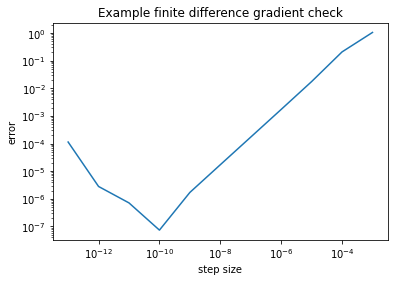

In [82]:
# step_sizes = [1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13]


# Make log-log plot of gradient finite difference error vs. step size

A1 = np.random.uniform(0,5)
L1 = forward_model_cost(np.array([A1, w]), V0, m, h, n, dt, t, data_steps, V_data)

# compute gradient using autograd
g = grad_AD(np.array([A1, w]), V, m, h, n, dt, t, data_steps, V_data)[0]
dL_dV_p = np.dot(g, p)

# j = jac_AD(V1, m, h, n, I_stimulus, dt, t, data_steps, V_data)
# dL_dV_p = np.dot(j, p)


grad_errs = list()
for s in step_sizes:
    
    # compute gradient using finite differences
    A2 = A1 + s*p

    L2 = forward_model_cost(np.array([A2, w]), V0, m, h, n, dt, t, data_steps, V_data)
    dL_dV_p_diff = (L2 - L1) / s


    # compute gradient error
    grad_err = np.abs( (dL_dV_p - dL_dV_p_diff) / dL_dV_p_diff )
    print('step size=', s, ', example gradient finite difference error=', grad_err)
    
    grad_errs.append(grad_err)

plt.loglog(step_sizes, grad_errs)
plt.title('Example finite difference gradient check')
plt.xlabel('step size')
plt.ylabel('error')




# step_sizes = [1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13]


# # Make log-log plot of gradient finite difference error vs. step size

# w1 = np.random.uniform(0, 1)
# L1 = forward_model_cost(V0, m, h, n, np.array([A, w1]), dt, t, data_steps, V_data)


# # compute gradient using autograd
# g = grad_AD(V, m, h, n, np.array([A, w1]), dt, t, data_steps, V_data)[1]
# dL_dV_p = np.dot(g, p)


# grad_errs = list()
# for s in step_sizes:
    
#     # compute gradient using finite differences
#     w2 = w1 + s*p

#     L2 = forward_model_cost(V0, m, h, n, np.array([A, w2]), dt, t, data_steps, V_data)
#     dL_dV_p_diff = (L2 - L1) / s


#     # compute gradient error
#     grad_err = np.abs( (dL_dV_p - dL_dV_p_diff) / dL_dV_p_diff )
#     print('step size=', s, ', example gradient finite difference error=', grad_err)
    
#     grad_errs.append(grad_err)

# plt.loglog(step_sizes, grad_errs)
# plt.title('Example finite difference gradient check')
# plt.xlabel('step size')
# plt.ylabel('error')



#### Find Minimizer

In [86]:
# A = 4.289
# w = 0.1

initial_guess =

optimize.minimize(forward_model_cost, np.array([A, w]), args = (V0, m, h, n, dt, t, data_steps, V_data), 
                  jac = grad_AD, method = 'BFGS')







      fun: 9189.044151073544
 hess_inv: array([[ 1.54559372e-04, -4.83114860e-06],
       [-4.83114860e-06,  1.51013537e-07]])
      jac: array([0.00015149, 0.00484575])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 30
      nit: 18
     njev: 30
   status: 2
  success: False
        x: array([4.3420088, 0.0983082])

In [70]:
# Steepdest Descent

from scipy import optimize

L_func = lambda A: forward_model_cost(V, m, h, n, np.array([A, w]), dt, t, data_steps, V_data)
g_func = lambda A: grad_AD(V, m, h, n, np.array([A, w]), dt, t, data_steps, V_data)[0]
#j_func = lambda V: jac_AD(V, m, h, n, I_stimulus, dt, t, data_steps, V_data)

L0 = L_func(A)
g0 = g_func(A)
norm_g0 = np.linalg.norm(g0)

LL_sd = list()
LL_sd.append(L0) # Keep appending the value of J to this list each iteration

gradnorms_sd = list()
gradnorms_sd.append(norm_g0) # keep appending the value of ||g|| each iteration



# Solve optimization problem using method of steepest descent. 

Ak = A
#Ak = 10.0
norm_gk = norm_g0

while norm_gk >= 1e-6 * norm_g0:
    
    #bk = optimize.line_search(L_func, g_func, Ak, -g_func(Ak))[0]
    bk = 1e-4
    print(Ak)
    print(bk)
    print(g_func(Ak))
    
    Ak = Ak - bk * g_func(Ak)
    g_k = g_func(Ak)
    norm_gk = np.linalg.norm(g_k)
    
    print(Ak)
    print(bk)
    print(g_func(Ak))
    
    LL_sd.append(L_func(Ak))
    gradnorms_sd.append(norm_gk)


    
# Now the solution should be in the variable u
# and LL_sd should be a list, with LL[k] = L(V_k)

LL_sd = np.array(LL_sd) # Make JJ_sd into array instead of list
gradnorms_sd = np.array(gradnorms_sd)
#jacnorms_sd = np.array(jacnorms_sd)




# L_func = lambda w: forward_model_cost(V, m, h, n, np.array([A, w]), dt, t, data_steps, V_data)
# g_func = lambda w: grad_AD(V, m, h, n, np.array([A, w]), dt, t, data_steps, V_data)[1]

# L0 = L_func(w)
# g0 = g_func(w)
# norm_g0 = np.linalg.norm(g0)

# LL_sd = list()
# LL_sd.append(L0) # Keep appending the value of J to this list each iteration

# gradnorms_sd = list()
# gradnorms_sd.append(norm_g0) # keep appending the value of ||g|| each iteration



# # Solve optimization problem using method of steepest descent. 

# #Ak = A
# wk = w
# norm_gk = norm_g0
# count = 0

# while norm_gk >= 1e-6 * norm_g0:
    
#     bk = optimize.line_search(L_func, g_func, wk, -g_func(wk))[0]
    
#     wk = wk - bk * g_func(wk)
#     g_k = g_func(wk)
#     norm_gk = np.linalg.norm(g_k)
    
#     LL_sd.append(L_func(wk))
#     gradnorms_sd.append(norm_gk)
#     count += 1


    
# # Now the solution should be in the variable u
# # and LL_sd should be a list, with LL[k] = L(V_k)

# LL_sd = np.array(LL_sd) # Make JJ_sd into array instead of list
# gradnorms_sd = np.array(gradnorms_sd)
# #jacnorms_sd = np.array(jacnorms_sd)




4.289
0.0001
21793.44283367085
2.1096557166329144
0.0001
-1677.103744546458
2.1096557166329144
0.0001
-1677.103744546458
2.2773660910875604
0.0001
-1571.5559529844288
2.2773660910875604
0.0001
-1571.5559529844288
2.4345216863860033
0.0001
-1468.9964265785015
2.4345216863860033
0.0001
-1468.9964265785015
2.5814213290438532
0.0001
-1369.6492288103777
2.5814213290438532
0.0001
-1369.6492288103777
2.718386251924891
0.0001
-1273.849540227273
2.718386251924891
0.0001
-1273.849540227273
2.845771205947618
0.0001
-1182.0174795077846
2.845771205947618
0.0001
-1182.0174795077846
2.9639729538983968
0.0001
-1094.63222337898
2.9639729538983968
0.0001
-1094.63222337898
3.073436176236295
0.0001
-1012.2082461268014
3.073436176236295
0.0001
-1012.2082461268014
3.174657000848975
0.0001
-935.276245081098
3.174657000848975
0.0001
-935.276245081098
3.2681846253570845
0.0001
-864.3721348558125
3.2681846253570845
0.0001
-864.3721348558125
3.354621838842666
0.0001
-800.0386591835279
3.354621838842666
0.0001
-8

KeyboardInterrupt: 

In [68]:
wk, gradnorms_sd, bk, g_func(Ak), Ak

#wk - bk * g_func(wk)

# L0, g0, norm_g0
# count


(1.0, array([21793.44283367,            nan]), 1024.0, nan, -22316481.17267895)

In [ ]:
#grad_AD(V, m, h, n, np.array([10.0, w]), dt, t, data_steps, V_data)[0]
temp = integrate_HH(V0, m, h, n, np.array([10.0, w]), dt, t)
plt.plot(temp)

In [ ]:
norm_g = np.linalg.norm(g_func(Ak))
print('||g(u)|| / ||g(u_0)||=', norm_g / norm_g0) # should be less than 1e-6

#u_including_endpoints = np.concatenate([[0], uk, [0]])

V_final = integrate_HH(V0, m, h, n, np.array([Ak, w]), dt, t)

plt.figure()
plt.plot(V_final)
plt.title('V (steepest descent)')
plt.xlabel('time')
plt.ylabel('V')